In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This notebook is the first architecture experiment. Modifications done:
1. remove the nn.embedding
2. added a dot product before final predictor layer

Also analysis as to why performance was poor is done

# Imports

In [21]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation, plot_activation_heatmap_and_density
from utils.graph_model import Experiment_1
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set up

In [3]:
seed_everything()

In [4]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

In [5]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [6]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [7]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out 
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [8]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [9]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [10]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [11]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [12]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Model

In [13]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [14]:
# Instantiate the model
model = Experiment_1(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [15]:
# move the model 
model.to(device)

Experiment_1(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Add hook 

This will help track the outputs

In [16]:
# Record activations for visualization
activations = {}  # Dictionary to store activations
def hook_fn(module, input, output):
    """Hook function to capture activations."""
    activations[module] = output
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)
model.user_feature_transform.register_forward_hook(hook_fn)
model.product_feature_transform.register_forward_hook(hook_fn)

# Train

In [17]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 2.0338, Val Loss: 2.0297, best model epoch: 100
Epoch: 200, Train Loss: 0.8799, Val Loss: 0.9224, best model epoch: 199
Epoch: 300, Train Loss: 0.7881, Val Loss: 0.7506, best model epoch: 262
Epoch: 400, Train Loss: 0.5220, Val Loss: 0.4896, best model epoch: 398
Epoch: 500, Train Loss: 0.4545, Val Loss: 0.4535, best model epoch: 441
Epoch: 600, Train Loss: 1.1777, Val Loss: 0.8762, best model epoch: 587
Epoch: 700, Train Loss: 0.3372, Val Loss: 0.2621, best model epoch: 700
Epoch: 800, Train Loss: 0.5388, Val Loss: 0.6192, best model epoch: 768
Epoch: 900, Train Loss: 0.2511, Val Loss: 0.2191, best model epoch: 768
Epoch: 1000, Train Loss: 0.1956, Val Loss: 0.1909, best model epoch: 995


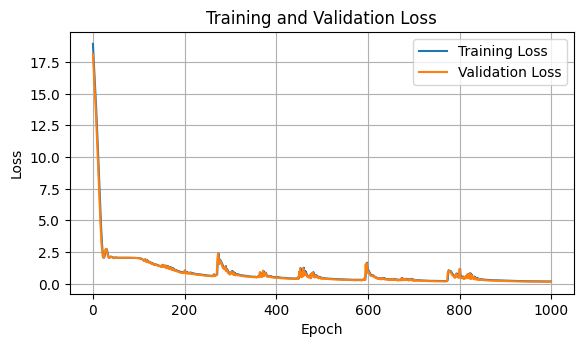

In [18]:
plot_train_val_loss(train_loss, test_loss)

# Analysing predictions

Previoulsy we have seen that the MSE of the model can be lowered. However, based on recommendations, they are generally constant. This section will analyse why

**WARN**  
This is the old explanation that is copied over. Need to change for the new data  

**Text**   
Visualizing acitivation outputs yield interesting results. We visualize the activation outputs in reversed order, in order to get intuition of why we are getting constant ratings for all users. Key observations as follows:
- In the final conv2 activation output, we see that user embeddings have much greater heterogeneity (first ~600,000 rows) compared to product embeddings (latter ~80,000 rows). The homogeneity of product embeddings explains why we are producing constant recommendations regardless of selected user, since the baseGNN model now uses dot product of user embeddings and product embeddings (with some MLP layers) to get ratings. Let's try to figure out why we are not learning effective embeddings for products by visualizing earlier layers. Two hypotheses: (i) Our product feature inputs are not meaningful (ii) Our GNN architecture is "smoothing" out product embeddings too much from the GCN Conv layers, which essentially combines one's existing embeddings and neighbour's embeddings to form new set of embeddings.
- In conv1 activation output, we see some degree of heterogeneity in the product embeddings, though still relatively homogenous. I guess we cannot ascertain whether hypotheses (i) or (ii) is causing this, but what it does confirm is that GCNConv does cause a smoothing effect.
- In product_feature_transform output, we see even more heterogeneity in product features. That said, it still has less variance compared to user_feature_transform activation output.

Hypotheses:
- 1/ One suspicion is that our product-level review embeddings are not meaningful. We can verify this by initializing random product-level review embeddings to see how well the model trains. This is tackled in section (2) of diagnostic tests.
- 2/ Another hypotheses is we are washing out product-level signals with our GNN architecture. We can try changing the architecture to better capture embedding characteristics. This is tackled in section (3) of diagnostic tests.

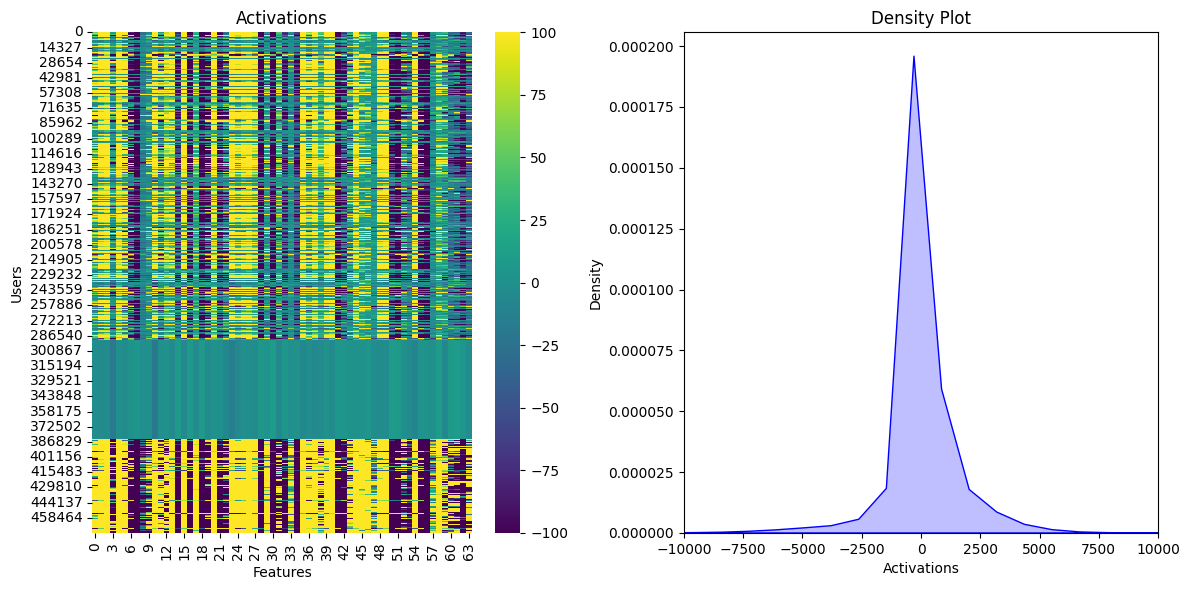

In [ ]:
# Visualize activations of conv2 activation output
activations_of_interest = activations[model.conv2].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

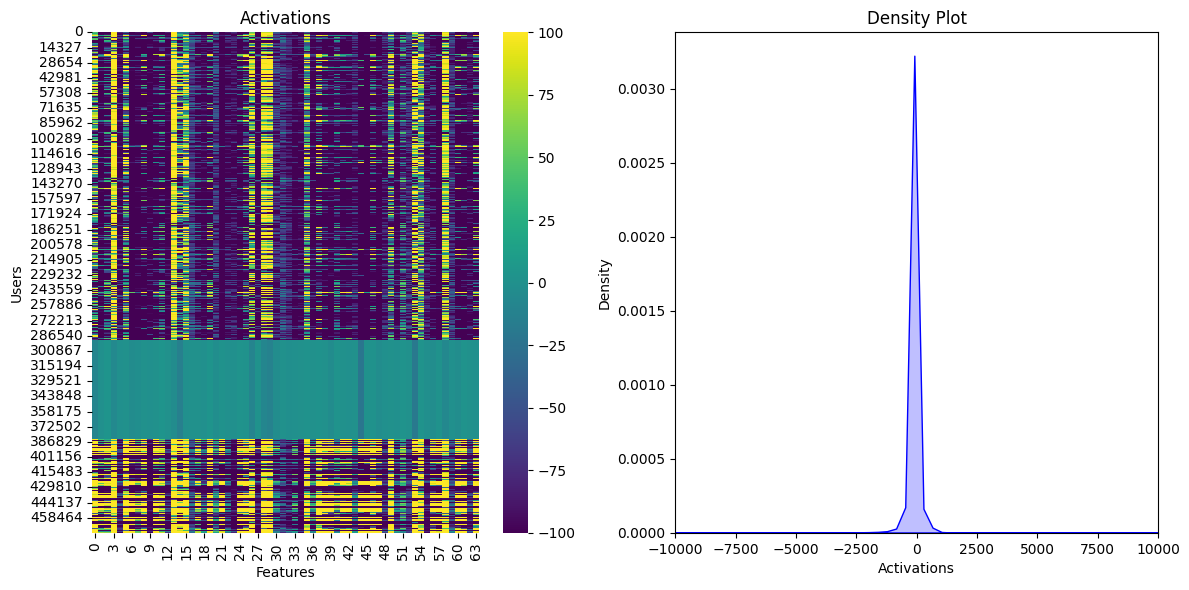

In [24]:
# Visualize activations of conv1 activation output
activations_of_interest = activations[model.conv1].detach().cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

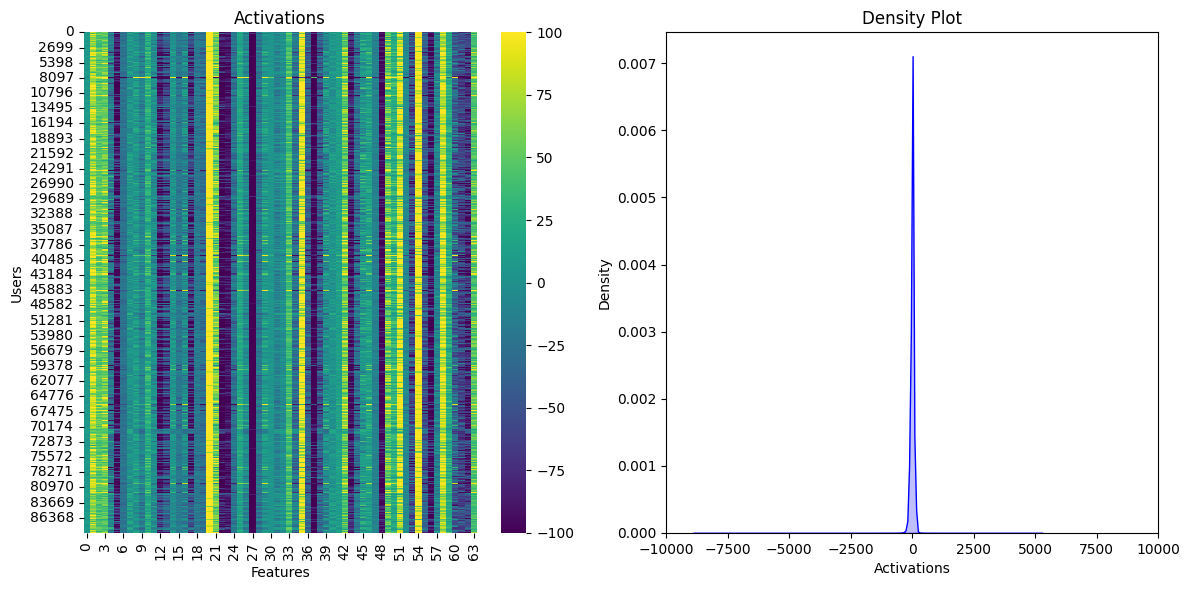

In [26]:
# Visualize activations of product_feature_transform activation output
activations_of_interest = activations[model.product_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

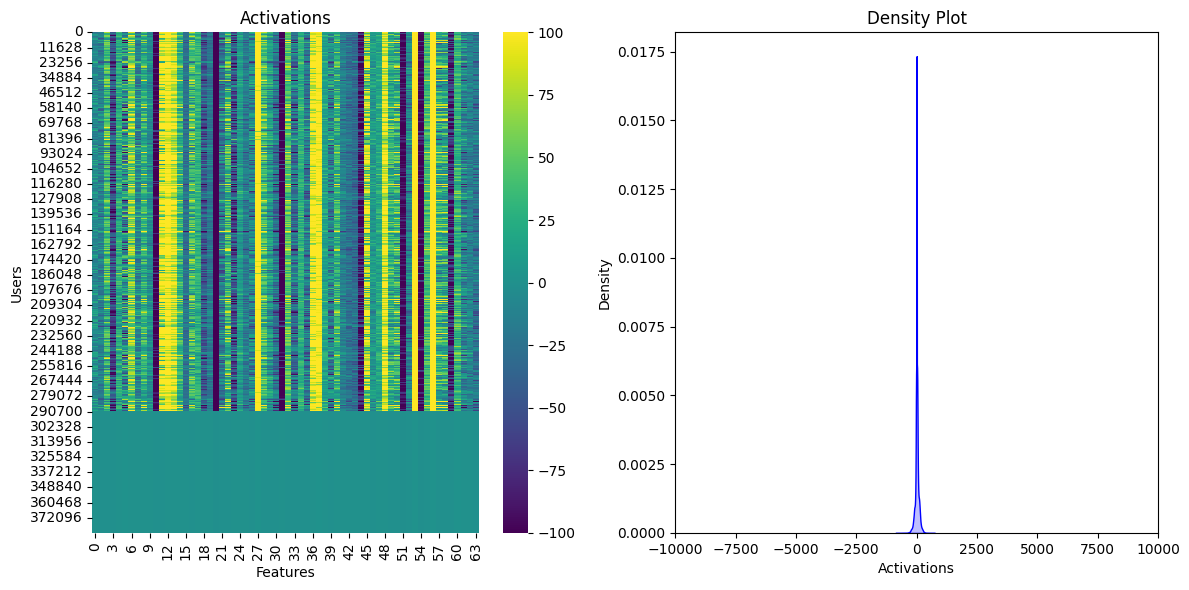

In [27]:

# Visualize activations of user_feature_transform activation output
activations_of_interest = activations[model.user_feature_transform].cpu().numpy()
plot_activation_heatmap_and_density(activations_of_interest)

# Test

Test loss: 0.1626


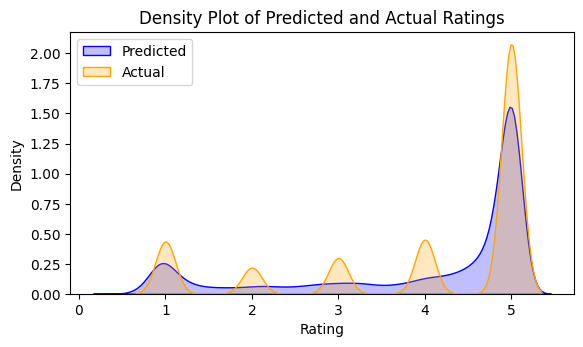

In [28]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, True)

# Recomendations 

In [29]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [30]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 2: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 3: 65W USB C Fast Charger WOTOBEUS 12W USB Wall Plug PD QC 3.0 Type C Power Adapter for iPhone 12 Pro Max Mini iPad MacBook Samsung Galaxy Phone S21 S20 Note 20 10 Plus Ultra Pixel HP Dell Leveno Laptop
Product 4: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 5: Phone Headphone Adapter ZJT4-0810-VP705
Product 6: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 7: The Writer 10th Anniversary Edition
Product 8: ZARA Woman Eau de Toilette WONDER ROSE 30ml/1.02 fl .oz
Product 9: WMYCONGCONG 2 PCS TRX Style Female to T Plug Male Conn

In [31]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [32]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 2: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 3: 65W USB C Fast Charger WOTOBEUS 12W USB Wall Plug PD QC 3.0 Type C Power Adapter for iPhone 12 Pro Max Mini iPad MacBook Samsung Galaxy Phone S21 S20 Note 20 10 Plus Ultra Pixel HP Dell Leveno Laptop
Product 4: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 5: Phone Headphone Adapter ZJT4-0810-VP705
Product 6: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 7: The Writer 10th Anniversary Edition
Product 8: ZARA Woman Eau de Toilette WONDER ROSE 30ml/1.02 fl .oz
Product 9: WMYCONGCONG 2 PCS TRX Style Female to T Plug Male Conn

In [33]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance 
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [34]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 2: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 3: 65W USB C Fast Charger WOTOBEUS 12W USB Wall Plug PD QC 3.0 Type C Power Adapter for iPhone 12 Pro Max Mini iPad MacBook Samsung Galaxy Phone S21 S20 Note 20 10 Plus Ultra Pixel HP Dell Leveno Laptop
Product 4: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 5: Phone Headphone Adapter ZJT4-0810-VP705
Product 6: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 7: The Writer 10th Anniversary Edition
Product 8: ZARA Woman Eau de Toilette WONDER ROSE 30ml/1.02 fl .oz
Product 9: WMYCONGCONG 2 PCS TRX Style Female to T Plug Male Conn

In [35]:
# count more than 10 purchases
min_unique_purchase = 10
item_count_df = test_user_edges.groupby("user_id").prod_idx.apply(lambda x: len(set(x))).reset_index()
dense_user_id = item_count_df[item_count_df["prod_idx"] >= min_unique_purchase][["user_id"]]

In [44]:
user_id = dense_user_id.user_id.sample(1).item()
recommended_products, predictions, pred_ratings = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, ratings = True, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")
print(pred_ratings)

Product 1: Micro USB Cable,Pashion 3ft Premium Micro USB Charging Cable High Speed USB 2.0 A Male to Micro B Charge Cables for Android
Product 2: Atelier Cologne Mandarine Glaciale sample size vial 0.067 oz
Product 3: 65W USB C Fast Charger WOTOBEUS 12W USB Wall Plug PD QC 3.0 Type C Power Adapter for iPhone 12 Pro Max Mini iPad MacBook Samsung Galaxy Phone S21 S20 Note 20 10 Plus Ultra Pixel HP Dell Leveno Laptop
Product 4: 4pcs 1 pair 3 Magnet 3D Magnetic Eyelashes Magnet Lashes Thicker Reusable False Eyelashes Handmade No Glue Eye Lashes Makeup Kit
Product 5: Phone Headphone Adapter ZJT4-0810-VP705
Product 6: Werkryt MFi Certified iPhone Charger Lightning Cable 5 Pack [3/3/6/6/10FT] Extra Long Nylon Braided USB Charging & Syncing Cord Compatible iPhone Xs/Max/XR/X/8/8Plus/7/7Plus/6S/6S Plus/SE/iPad/Nan Mor
Product 7: The Writer 10th Anniversary Edition
Product 8: ZARA Woman Eau de Toilette WONDER ROSE 30ml/1.02 fl .oz
Product 9: WMYCONGCONG 2 PCS TRX Style Female to T Plug Male Conn